Some scripts to analyze the csv-files produced by the testing function

In [1]:
import pandas as pd
import numpy as np
import torch
import os.path

In [2]:
# Just as a test:
dfConfusion = pd.read_csv("../../ots_prelim/swin_b/swin_b_adam_batch256_imnetnorm_confusiona.csv")
dfPredictions = pd.read_csv("../../ots_prelim/swin_b/swin_b_adam_batch256_imnetnorm_predictionsa.csv")

In [3]:
def getNumpyConfusionMatrix(df: pd.DataFrame) -> np.ndarray:
    materials = df.columns[1:].to_list()
    return df[materials].to_numpy()

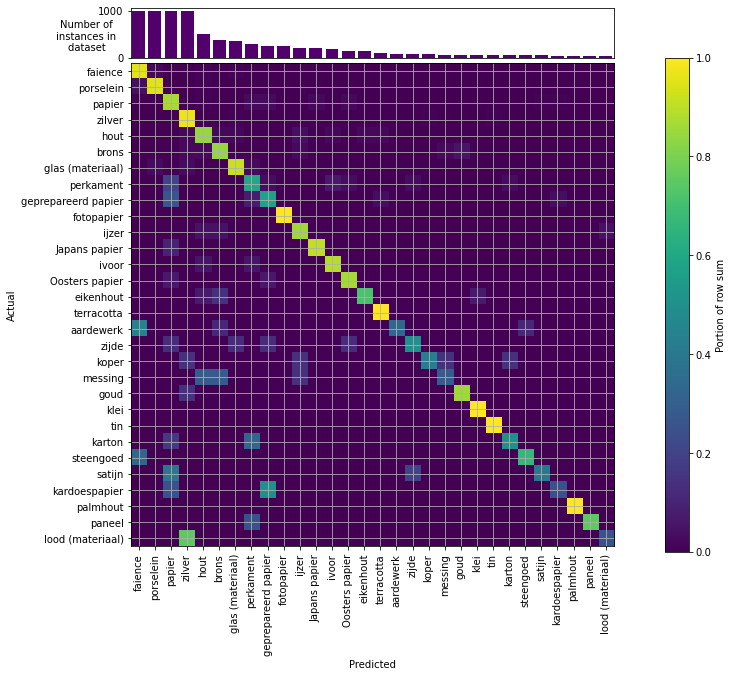

In [170]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

cm = getNumpyConfusionMatrix(dfConfusion)
cm = cm / np.sum(cm, axis=0)

#histDf = pd.read_csv("../data_annotations/fullsize-hist.csv")

plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 10], width_ratios=[20, 1])

conf = plt.subplot(gs[2])
c = conf.imshow(cm.T)
plt.setp(hist.get_yticklabels(), visible=False)
conf.set_xticks([x for x in range(30)])
conf.set_xticklabels(dfConfusion.columns.to_list()[1:], rotation="vertical")
conf.set_yticks([x for x in range(30)])
conf.set_yticklabels(dfConfusion.columns.to_list()[1:])
conf.grid()
conf.set_xlabel("Predicted")
conf.set_ylabel("Actual")

hist = plt.subplot(gs[0], sharex=conf)
hist.bar(histDf["material"], histDf["count"], color="#51006c")
hist.xaxis.set_visible(False)
hist.set_ylabel("Number of     \ninstances in     \ndataset     ", rotation="horizontal", position=(0,0.1))

cbar = plt.subplot(gs[3])
cb = plt.colorbar(c, cax=cbar)
cb.set_label("Portion of row sum")

plt.subplots_adjust(hspace=-.0)
plt.show()

In [4]:
# True positives, True Negatives, etc
def extractRates(df: pd.DataFrame):
    cm = getNumpyConfusionMatrix(df).T
    TP = cm.diagonal()
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - TP - FP - FN
    return {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "TN": TN
    }

In [5]:
def perClassMetrics(df: pd.DataFrame) -> pd.DataFrame:
    materials = df.columns.to_list()[1:]
    rates = extractRates(df)
    recall = rates["TP"] / (rates["TP"] + rates["FN"])
    precision = rates["TP"] / (rates["TP"] + rates["FP"])
    specificity = rates["TN"] / (rates["TN"] + rates["FP"])

    return pd.DataFrame.from_dict({
        "materials": materials,
        "recall [TP/(TP+FN)]": recall,
        "precision [TP/(TP+FP)]": precision,
        "TP": rates["TP"],
        "FP": rates["FP"],
        "FN": rates["FN"],
        "TN": rates["TN"]
    })

In [27]:
def getTestMetrics(dfConf: pd.DataFrame, dfPred: pd.DataFrame):
    dfPc = perClassMetrics(dfConf)
    accuracy = np.sum(dfPc["TP"]) / np.sum(dfPc["TP"] + dfPc["FP"])
    balanced_accuracy = np.sum(dfPc["recall [TP/(TP+FN)]"]) / len(dfPc)
    
    predictions = torch.from_numpy(dfPred[dfConf.columns[1:]].to_numpy())
    actual = torch.from_numpy(dfPred["actual_idx"].to_numpy())
    top2 = torch.topk(predictions, 2)
    top3 = torch.topk(predictions, 3)
    top5 = torch.topk(predictions, 5)
    acc2 = 0
    acc3 = 0
    acc5 = 0
    for pred2, pred3, pred5, act in zip(top2[1], top3[1], top5[1], actual):
        acc2 += (act in pred2)
        acc3 += (act in pred3)
        acc5 += (act in pred5)
    acc2 /= len(actual)
    acc3 /= len(actual)
    acc5 /= len(actual)

    return {
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        "top-2_accuracy": acc2,
        "top-3_accuracy": acc3,
        "top-5_accuracy": acc5
    }

In [28]:
# Looping over all models and extracting statistics of interest
def getFiles(root: str, target: str):
    dirs = [dir for dir in os.scandir(root) if dir.is_dir()]
    files = {}
    for dir in dirs:
        for file in os.scandir(dir):
            if file.is_file() and target in str(file.path):
                files[dir.name] = file.path
    return files

In [70]:
confusions = getFiles("../../ots_prelim", "confusion")
predictions = getFiles("../../ots_prelim", "predictions")

all_metrics = []
for key in confusions:
    metrics = getTestMetrics(pd.read_csv(confusions[key]), pd.read_csv(predictions[key]))
    all_metrics += [[key, metrics["accuracy"], metrics["balanced_accuracy"], metrics["top-2_accuracy"], metrics["top-3_accuracy"], metrics["top-5_accuracy"]]]

df = pd.DataFrame(all_metrics, columns=["model", "accuracy", "balanced_accuracy", "top-2_accuracy", "top-3_accuracy", "top-5_accuracy"])
df

<ipython-input-5-63838cffd56c>:5: RuntimeWarning: invalid value encountered in true_divide
  precision = rates["TP"] / (rates["TP"] + rates["FP"])


,model,accuracy,balanced_accuracy,top-2_accuracy,top-3_accuracy,top-5_accuracy
0,vgg19,0.775095,0.637283,0.894536,0.936468,0.970775
1,efficientnetv2_b,0.743329,0.602882,0.858958,0.903431,0.947903
2,resnet50,0.808132,0.666999,0.895807,0.935197,0.964422
3,swin_b,0.856417,0.732654,0.941550,0.966963,0.988564
4,vit_b_16,0.777637,0.675125,0.891995,0.937738,0.966963
5,convnext_b,0.820839,0.682939,0.914867,0.949174,0.980940
6,beit_b,0.777637,0.631982,0.883100,0.928844,0.963151


In [71]:
modelmap = {
    "vit_b_16": 0,
    "swin_b": 1,
    "beit_b": 2,
    "vgg19": 3,
    "resnet50": 4,
    "convnext_b": 5,
    "efficientnetv2_b": 5
}
df["rank"] = df["model"].apply(lambda x: modelmap[x])
df = df.sort_values("rank").reset_index().drop(["index", "rank"], axis=1)
df

,model,accuracy,balanced_accuracy,top-2_accuracy,top-3_accuracy,top-5_accuracy
0,vit_b_16,0.777637,0.675125,0.891995,0.937738,0.966963
1,swin_b,0.856417,0.732654,0.941550,0.966963,0.988564
2,beit_b,0.777637,0.631982,0.883100,0.928844,0.963151
3,vgg19,0.775095,0.637283,0.894536,0.936468,0.970775
4,resnet50,0.808132,0.666999,0.895807,0.935197,0.964422
5,efficientnetv2_b,0.743329,0.602882,0.858958,0.903431,0.947903
6,convnext_b,0.820839,0.682939,0.914867,0.949174,0.980940


In [72]:
df.to_csv("model_accuracies.csv")